# Birds Exercise
- We want to build a model that can recognize what is a bird and not a bird from photos.
- Images are represented by pixels (numbers).

## Steps
1. Download images from DuckDuckGo of birds and non-birds (forests).
2. Train the model - i.e. fine-tune a pretrained neural network to recognise these two groups.
3. Try running the model and see if it works.

In [94]:
import time
from duckduckgo_search import DDGS 
import fastcore.all as fc 
from fastdownload import download_url
import fastai.vision.all as fv
import fastai.tabular.all as ft
import fastai.collab as f_collab

def search_images(keywords, max_images=200): return fc.L(DDGS().images(keywords, max_results=max_images)).itemgot('image')

# Step 1: Download images 
- download images from DuckDuckGo search engine of birds and non-birds
- for non-birds, let's search for forests; because we can't search duckduckgo for non-bird
- remove images that failed to download correctly

getting a bird photo
len(urls)=1, urls[0]='https://images.pexels.com/photos/97533/pexels-photo-97533.jpeg?cs=srgb&dl=animal-avian-bird-97533.jpg&fm=jpg'


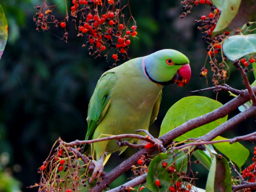

In [72]:

# get a bird photo
print("getting a bird photo")
urls = search_images('bird photos', max_images=1)  # search for image in duck duck go search engine
print(f'{len(urls)=}, {urls[0]=}')

dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=True)
im = fv.Image.open(dest)
im.to_thumb(256, 256)

getting a forest photo


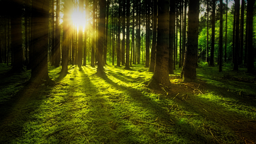

In [73]:
# get a forest photo
print("getting a forest photo")
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=True)
im = fv.Image.open('forest.jpg')
im.to_thumb(256, 256)

In [76]:
searches = 'forest', 'bird'
path = fc.Path('bird_or_not')

if path.exists():
    print("images downloaded already")
else:
    print("downloading images...")
    for o in searches:
        dest = (path/o)
        dest.mkdir(exist_ok=True, parents=True)
        # for fastai download_images function, provide a list of urls, does this quickly in parallel
        fv.download_images(dest, urls=search_images(f'{o} photo'))
        time.sleep(5)
        # for computer vision models, you don't need big images
        fv.resize_images(path/o, max_size=400, dest=path/o)  # image no bigger than 400x400 pixels

downloading images...


In [77]:
# remove images that failed to download correctly
# fv.get_image_files() is a function that returns a list of image files based on extension
failed = fv.verify_images(fv.get_image_files(path))  # path is Path object bird_or_not directory
failed.map(fc.Path.unlink)  # functional style
print(f'{len(failed)=}')


len(failed)=14


# Step 2: Train the model
- create a DataLoaders object, this contains a training set and a validation set
- use a pre-traimed computer vision model, resnet18, and fine-tune it. resenet is pretrained on imagenet with 1 million images covering 1000 categories.
- `fastai` comes with a helpful fine_tune() method which automatically uses best practices for fine tuning a pre-trained model. fine tuning means adjusting the model's weights a little bit so that the model learns to recognize this new dataset. 
- reference [docs.fast.ai](https://docs.fast.ai/) for tutorials and underlying data information
- refrence [Pytorch Image Models (timm)](https://timm.fast.ai/). any of these models can be used in the fastai learner

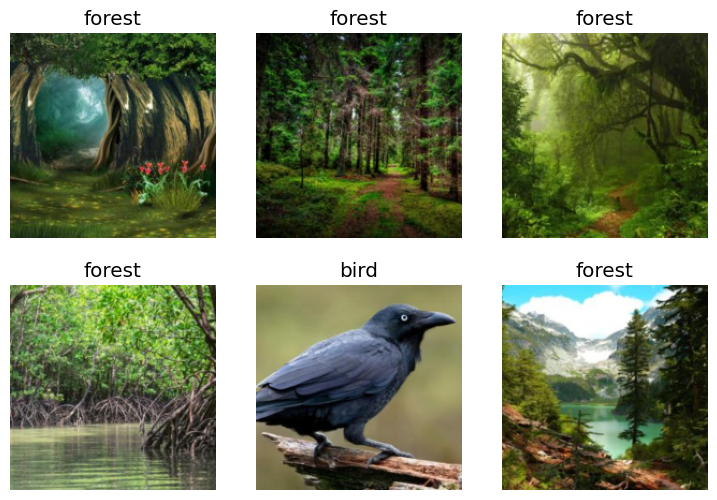

In [78]:
# how to get data into the model?
dls = fv.DataBlock(
    blocks = (fv.ImageBlock, fv.CategoryBlock),  # imputs to model are images and outputs are categories 'bird' and 'forest' 
    get_items = fv.get_image_files,  # to get all the inputs, run the get_image_files function, which returns a list of all image files in the path
    splitter = fv.RandomSplitter(valid_pct=0.2, seed=42),  # randomly split data into 80% training and 20% validation
    get_y = fv.parent_label,  # the labels (y values) is the name of the parent of each file, aka name of folder that images are in, 'bird' or 'forest'
    # item_tfms stands for item transforms, the transforms run on every image in the dataset; computer vision model meeds all the images to be of the same size
    item_tfms = [fv.Resize(192, method='squash')],  # before training, resize each image to 192x192 pixels by squishing (as opposed to cropping) 
).dataloaders(path, bs=32)

# show_batch() shows a batch of data that will be passed into the model
# it tells you 2 things: 1) the input (the picture), and 2) the label
dls.show_batch(max_n=6)

In [79]:
# learner - comnbines a model and data to train the model
# the model is the neural netowrk function - you can use any one of the Pytorch Image Models (timm)
# model resnet18 should be fine for most purposes, fun to try different models
# fastai donwloads the weights of the pre-trained model for you
learn = fv.vision_learner(dls, fv.resnet18, metrics=fv.error_rate)
learn.fine_tune(3)  # 3 epochs
# fine_tune() takes those pre-trained weights, and adjust them 
# to teach the model the difference between your dataset and what it was originally trained for

epoch,train_loss,valid_loss,error_rate,time
0,0.837602,0.194158,0.042857,00:02


epoch,train_loss,valid_loss,error_rate,time
0,0.043218,0.018503,0.014286,00:02
1,0.029053,0.019879,0.014286,00:02
2,0.036728,0.023791,0.014286,00:02


# Step 3: Use the model

In [80]:
category_string, category_integer, probs = learn.predict(fv.PILImage.create('bird.jpg'))
print(f'{len(probs)=}')
print(f'{probs.shape=}')
print('---')
print('looking at bird.jpg')
print(f'This is a: {category_string}')
print(f'Integer category: {category_integer}')
print(f'Probability it\'s a bird: {probs[0]:.4f}')
print(f'Probability it\'s a forest: {probs[1]:.4f}')

len(probs)=2
probs.shape=torch.Size([2])
---
looking at bird.jpg
This is a: bird
Integer category: 0
Probability it's a bird: 1.0000
Probability it's a forest: 0.0000


In [81]:
category_string, category_integer, probs = learn.predict(fv.PILImage.create('forest.jpg'))
print('looking at forest.jpg')
print(f'This is a: {category_string}')
print(f'Integer category: {category_integer}')
print(f'Probability it\'s a bird: {probs[0]:.4f}')

looking at forest.jpg
This is a: forest
Integer category: 1
Probability it's a bird: 0.0000


# Inspiration
- DALL-E - for generating pictures
- [practical data ethics](https://ethics.fast.ai/) course
- [meta learning](https://radekosmulski.com/the-post-tech-job-manifesto/)
- fastai is a library built on top of PyTorch

# Jupyter Notebook 101
- shift+enter to run cell
- cell starting with exclamation point is a bash command
- In the first cell, make sure to get the latest version of fastai. U flag is for upgrade, q flag is for quiet.`!pip install -Uqq fastai`

# Segmentation
- we can do more than image reconigition with images
- segmentation is where we take photos and in we color in every pixel
- brown is car, blue is fences, etc.
- so every pixel is classified (the target)
- and the model makes predictions


epoch,train_loss,valid_loss,time
0,3.982241,3.387055,00:02


epoch,train_loss,valid_loss,time
0,2.271023,1.863426,00:03
1,1.850484,1.530294,00:02
2,1.591857,1.252789,00:02
3,1.461364,1.371106,00:02
4,1.330151,1.139453,00:02
5,1.200145,1.045481,00:02
6,1.090595,0.998152,00:02
7,1.003182,0.976972,00:02


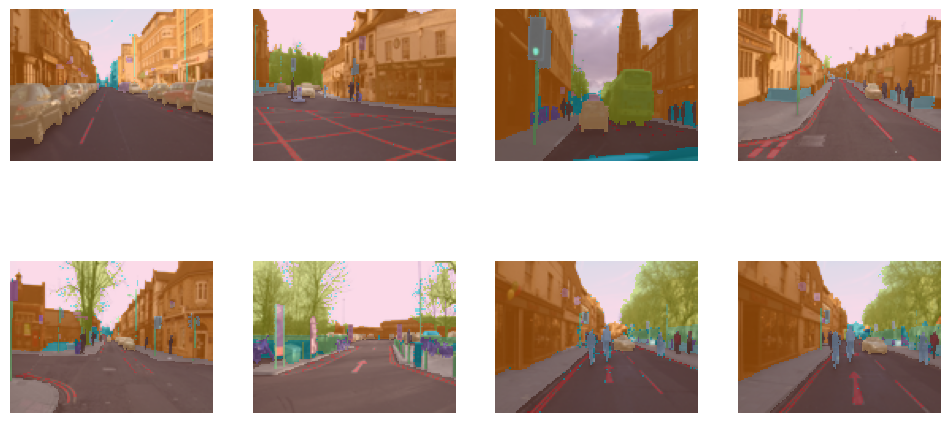

In [ ]:
# untar_data: a thin wrapper for FastDownload.get
# downloads and extracts by default to subdirectories of ~/.fastai
# returns the path to the extracted data
# reference: https://docs.fast.ai/data.external.html#untar_data
# CAMVID_TINY: A tiny camvid dataset for segmentation type models. 
# reference: https://docs.fast.ai/data.external.html

path_seg = fv.untar_data(fv.URLs.CAMVID_TINY)
fnames_seg = fv.get_image_files(path_seg/'images')
def label_func_seg(o): return path_seg/'labels'/f'{o.stem}_P{o.suffix}'
codes_seg = fv.np.loadtxt(path_seg/'codes.txt', dtype=str) 

dls_seg = fv.SegmentationDataLoaders.from_label_func(
    path_seg,  # path to put in dataloaders 
    fnames_seg,
    label_func_seg,
    bs=8,  # size of batch
    codes = codes_seg,  # what does each code mean in text file
)
dls_seg.show_batch()

learn_seg = fv.unet_learner(dls_seg, fv.resnet34)
learn_seg.fine_tune(8)

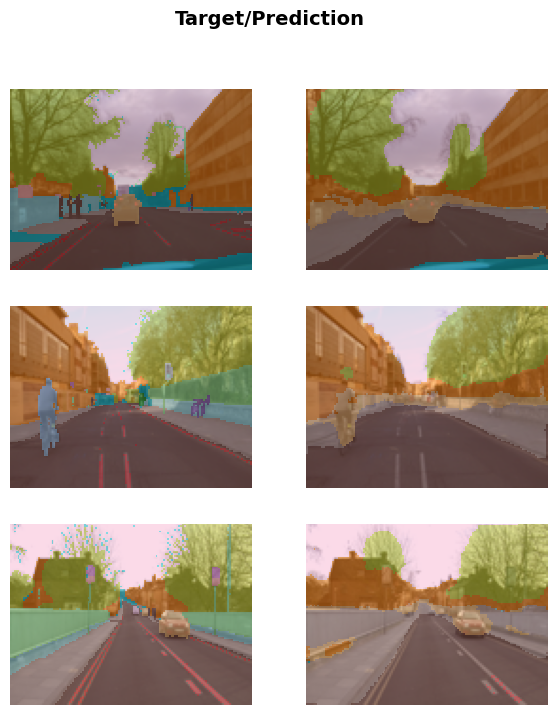

In [85]:
learn_seg.show_results(max_n=3, figsize=(7,8))

# Tabular Anaylsis

## Income Prediciton Example

In [88]:
# untar_data: downloads some data and decompresses it for you
# URLs: urls provided by fastai for common data sets
path_inc = ft.untar_data(ft.URLs.ADULT_SAMPLE)

dls_inc = ft.TabularDataLoaders.from_csv(
    path_inc/'adult.csv',
    path = path_inc, 
    y_names = "salary",
    # tell the dataloader which of the categories are categorical
    cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship'],
    # tell the dataloader which of the categories are continuous, aka can take any real number
    cont_names = ['age', 'fnlwgt', 'education-num'],
    procs = [ft.Categorify, ft.FillMissing, ft.Normalize]
)

dls_inc.show_batch()

/Users/denisesalazar/Documents/interview_prep_2025/practical_deep_learning/.venv/lib/python3.9/site-packages/fastai/tabular/core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)


,workclass,education,marital-status,occupation,relationship,education-num_na,age,fnlwgt,education-num,salary
0,Private,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,False,52.000000,195634.999869,9.0,<50k
1,Private,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,False,43.000000,174524.000584,9.0,>=50k
2,Federal-gov,HS-grad,Separated,Exec-managerial,Unmarried,False,27.000000,188342.999992,9.0,<50k
3,Private,Bachelors,Married-civ-spouse,Exec-managerial,Husband,False,33.000000,188245.999994,13.0,<50k
4,Federal-gov,Masters,Divorced,Protective-serv,Not-in-family,False,43.000000,186915.999961,14.0,>=50k
5,Local-gov,Some-college,Married-civ-spouse,Protective-serv,Husband,False,31.000000,209103.000387,10.0,<50k
6,Private,Bachelors,Married-civ-spouse,Sales,Husband,True,52.999999,302868.004213,10.0,>=50k
7,?,Some-college,Never-married,?,Own-child,False,21.000000,230396.999984,10.0,<50k
8,Private,Some-college,Never-married,Adm-clerical,Own-child,False,23.000000,186014.000011,10.0,<50k
9,Self-emp-not-inc,Bachelors,Married-civ-spouse,Sales,Husband,False,39.000000,190023.000047,13.0,<50k


In [90]:
learn_inc = ft.tabular_learner(dls_inc, metrics=ft.accuracy)
learn_inc.fit_one_cycle(2)

In [93]:
learn_inc.show_results()

,workclass,education,marital-status,occupation,relationship,education-num_na,age,fnlwgt,education-num,salary,salary_pred
0,5.0,10.0,3.0,13.0,6.0,1.0,-0.919796,0.561449,1.140668,1.0,1.0
1,2.0,16.0,3.0,14.0,1.0,1.0,1.425903,-1.020427,-0.034450,1.0,1.0
2,7.0,10.0,1.0,9.0,5.0,1.0,-0.186765,1.196161,1.140668,1.0,0.0
3,5.0,9.0,3.0,11.0,1.0,1.0,0.766175,-0.181722,0.357256,1.0,1.0
4,5.0,16.0,7.0,2.0,2.0,1.0,1.939024,-0.566814,-0.034450,0.0,0.0
5,5.0,12.0,3.0,4.0,1.0,1.0,-0.919796,-0.297330,-0.426157,0.0,0.0
6,5.0,13.0,3.0,14.0,1.0,1.0,1.205993,0.187264,1.532375,1.0,1.0
7,7.0,7.0,3.0,4.0,1.0,1.0,1.939024,-0.419640,-1.992982,0.0,0.0
8,8.0,9.0,3.0,5.0,1.0,1.0,0.986084,0.405739,0.357256,0.0,1.0


# Collaborative Filtering - Recommendation System
- collaborative filtering is the basis of recommendation systems today
- we take a dataset that says which users liked/used which products and use that to guess what other products that user may like based on finding similar ussers and those similar users like
- similar users means users who liked the same kind of products
- for example, you tell Spotify what you like and then Spotify recommends more like that

In [ ]:
# download and decompress data
path_collab = f_collab.untar_data(f_collab.URLs.ML_SAMPLE)  # this is the movie lens sample
dls_collab = f_collab.CollabDataLoaders.from_csv(path_collab/'ratings.csv')
dls_collab.show_batch()
# collaborative filtering data generally has a userid, some product id like movieid, and a rating

,userId,movieId,rating
0,88,4886,4.0
1,30,2762,5.0
2,150,1291,4.5
3,388,318,5.0
4,430,2858,5.0
5,268,10,3.0
6,509,1923,3.0
7,313,1923,4.0
8,313,253,4.0
9,292,592,3.5


In [ ]:
# input data and possible range for real number 1-5
# it's good to extend the range a little bit, little lower and little higher 0.5-5.5
learn_collab = f_collab.collab_learner(dls_collab, y_range=(0.5,5.5))
learn_collab.fine_tune(10)
# loss is the "mean squared error" i.e. on average how far off are we

epoch,train_loss,valid_loss,time
0,1.506339,1.365954,00:01


epoch,train_loss,valid_loss,time
0,1.375503,1.314366,00:00
1,1.293984,1.164927,00:00
2,1.071282,0.890204,00:00
3,0.835183,0.743059,00:00
4,0.698029,0.698016,00:00
5,0.665185,0.681911,00:00
6,0.667092,0.675490,00:00
7,0.621897,0.671381,00:00
8,0.605283,0.670332,00:00
9,0.639827,0.670148,00:00


In [99]:
learn_collab.show_results()

,userId,movieId,rating,rating_pred
0,92.0,99.0,4.5,3.983577
1,80.0,40.0,3.5,3.207723
2,59.0,8.0,4.0,4.075985
3,67.0,54.0,4.0,3.319826
4,93.0,48.0,5.0,3.870031
5,20.0,65.0,3.5,3.609929
6,92.0,62.0,4.0,4.193899
7,46.0,97.0,3.5,3.136393
8,21.0,35.0,4.0,3.636002


# What can machine learning do?
- Natural Language Processing (NLP)
- Computer vision
- Medicine
- Biology
- Image generation
- Recommendation systems
- Playing games
- Robotics

If a human can do it reasonably quickly, then that is probably something that deep learning can do.Arthur Samuel is one of the fathers of machine learning. 

# training procedure
- model takes in inputs and weights, produces results, calculate the loss (how good were the results), and then updates the weights; iterate
- weights are initiailized as random
- this process creates a computable function
- given enough time and enough data, you can solve anything

# inference
- the trained model takes in inputs and produces its results